In [1]:
import random
random.seed(42)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dataset_loader
import torchvision

import cv2
import numpy as np 

import matplotlib.pyplot as plt

In [2]:
cifar_dataset = dataset_loader.CIFAR10('./assets/cifar-10', train=True, download=True, transform=torchvision.transforms.ToTensor())

Files already downloaded and verified


In [3]:
cifar_dataset = cifar_dataset.data

(Text(0.5, 1.0, 'RGB'), Text(0.5, 1.0, 'Gray'))

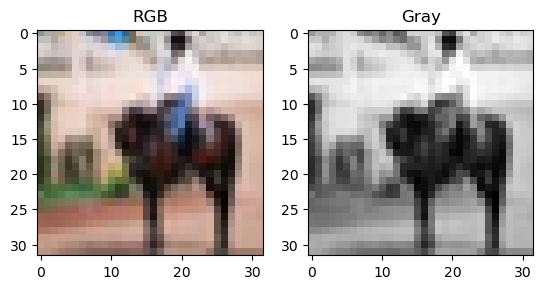

In [4]:
f, ax = plt.subplots(1,2)
ax[0].imshow(cifar_dataset[11])
ax[1].imshow(cv2.cvtColor(cifar_dataset[11], cv2.COLOR_RGB2GRAY),cmap='gray')
ax[0].set_title('RGB'), ax[1].set_title('Gray')

In [5]:
# Creating input and output data
batch_size = 100
op_data = np.array([cifar_dataset[_ix:_ix+batch_size] for _ix in range(0, cifar_dataset.shape[0], batch_size)])
ip_data = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in cifar_dataset])
ip_data = np.array([ip_data[_ix:_ix+batch_size] for _ix in range(0, ip_data.shape[0], batch_size)])

# Splitting the data
train_ratio, test_ratio = 0.8, 0.2
rand_ix = np.random.permutation(ip_data.shape[0])
train_ix, test_ix = rand_ix[:int(train_ratio*rand_ix.shape[0])], rand_ix[int(test_ratio*rand_ix.shape[0]):]
x_train, y_train, x_test, y_test = ip_data[train_ix,:,:], op_data[train_ix,:,:], ip_data[test_ix,:,:], op_data[test_ix,:,:]

(Text(0.5, 1.0, 'x_train'), Text(0.5, 1.0, 'y_train'))

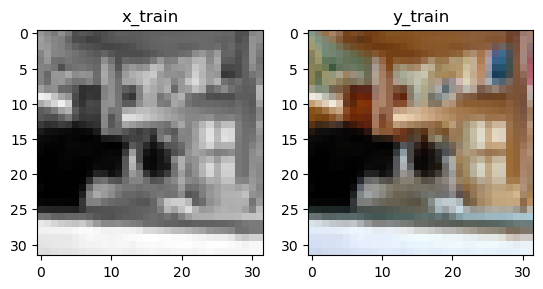

In [6]:
f, ax_1 = plt.subplots(1,2)
ax_1[0].imshow(x_train[0][0], cmap='gray')
ax_1[1].imshow(y_train[0][0])
ax_1[0].set_title('x_train'), ax_1[1].set_title('y_train')

In [7]:
def transform_and_create_torch_tensors(data):
    # reshaping the input and accelerate the tensor computations
    data = torch.from_numpy(data).float()
    return data.contiguous().view(data.size(0),batch_size,-1,32,32)

# transforming all the data.
x_train, y_train, x_test, y_test = map(transform_and_create_torch_tensors, [x_train, y_train, x_test, y_test])

In [8]:
mean = torch.mean(x_train[:,:,0,:,:])
std = torch.std(x_train[:,:,0,:,:])
print('mean: {}, std: {}'.format(mean, std))
x_train[:,:,0,:,:] = (x_train[:,:,0,:,:]-mean)/std
x_test[:,:,0,:,:] = (x_test[:,:,0,:,:]-mean)/std # using the mean and std from the training dataset
y_train = y_train/255
y_test = y_test/255

mean: 122.51787567138672, std: 60.985557556152344


In [9]:
class ConvNet(nn.Module):
    def __init__(self, batch_size):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.linear1 = nn.Linear(32*7*7, 512)
        self.linear2 = nn.Linear(512, 3072)

    def forward(self, x):
        # Encoder Phase
        p1 = F.max_pool2d(self.conv1(x), (2,2))
        p2 = F.max_pool2d(self.conv2(p1), (2,2))
        # Decoder Phase
        f1 = F.relu(self.linear1(p2.view(batch_size,-1)))
        f2 = torch.sigmoid(self.linear2(f1)).view(-1, 3, 32, 32)
        return f2

In [10]:
learning_rate = 0.0001
epochs = 200
criterion = torch.nn.MSELoss()

In [11]:
net = ConvNet(batch_size)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [12]:
train_loss_container, test_loss_container = [], []

'''for e in range(epochs):
    train_loss = 0.0
    test_loss = 0.0

    for batch, train_data in enumerate(x_train):
        ip, op = train_data, y_train[batch]
        optimizer.zero_grad()

        model_op = net(ip)
        loss = criterion(model_op, op)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for batch_test, test_data in enumerate(x_test, 0):
            ip_test, op_test = test_data, y_test[batch_test]
            model_op = net(ip_test)
            loss_test = criterion(model_op, op_test)
            test_loss += loss_test.item()

    train_loss_container.append(train_loss)
    test_loss_container.append(test_loss)
    print('\rEPOCH: {} | Train_loss: {} | Test_loss: {}'.format(e, train_loss, test_loss), end='')
print('\nFinished Training')'''

"for e in range(epochs):\n    train_loss = 0.0\n    test_loss = 0.0\n\n    for batch, train_data in enumerate(x_train):\n        ip, op = train_data, y_train[batch]\n        optimizer.zero_grad()\n\n        model_op = net(ip)\n        loss = criterion(model_op, op)\n        train_loss += loss.item()\n        loss.backward()\n        optimizer.step()\n\n    with torch.no_grad():\n        for batch_test, test_data in enumerate(x_test, 0):\n            ip_test, op_test = test_data, y_test[batch_test]\n            model_op = net(ip_test)\n            loss_test = criterion(model_op, op_test)\n            test_loss += loss_test.item()\n\n    train_loss_container.append(train_loss)\n    test_loss_container.append(test_loss)\n    print('\rEPOCH: {} | Train_loss: {} | Test_loss: {}'.format(e, train_loss, test_loss), end='')\nprint('\nFinished Training')"

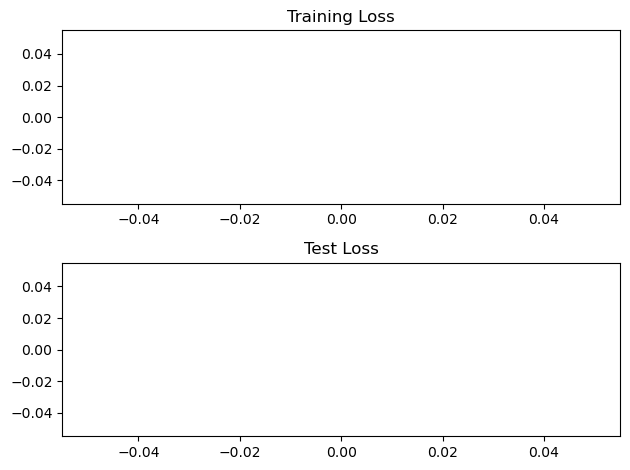

In [13]:
# Plotting the train and test loss as a function of epochs
f, ax = plt.subplots(2,1)
ax[0].set_title('Training Loss')
ax[0].plot(train_loss_container)
ax[1].set_title('Test Loss')
ax[1].plot(test_loss_container)
f.tight_layout()
plt.show()

In [14]:
# Load the saved model
model_path = './saved_model/model(2).pth'  # Update this path to your model file
batch_size = 100
model = ConvNet(batch_size)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=1568, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=3072, bias=True)
)

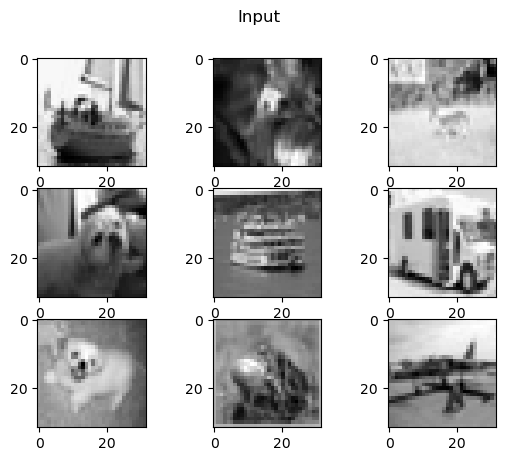

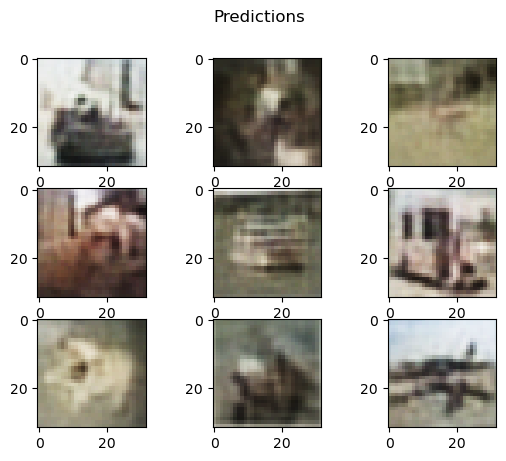

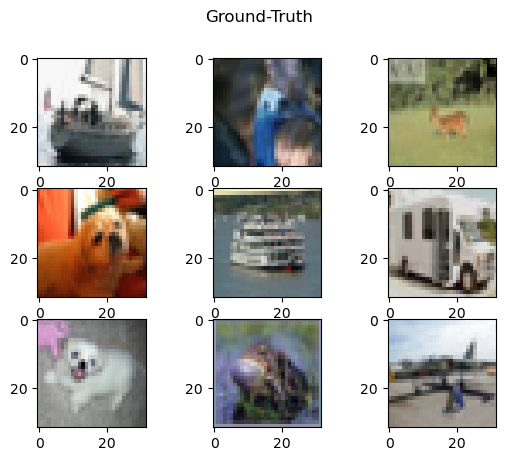

In [16]:
# input
f, ax = plt.subplots(3,3)
f.suptitle('Input')
for i in range(3):
    for j in range(3):
        tmp = mean.item() + x_test[i][j].detach().cpu().squeeze().numpy() * std.item()
        ax[i,j].imshow(tmp.reshape(32,32).astype(np.uint8), cmap='gray')

# prediction
f, ax = plt.subplots(3,3)
f.suptitle('Predictions')
for i in range(3):
    for j in range(3):
        tmp = model(x_test[i])[j].detach().cpu().numpy().reshape(32,32,3) * 255
        ax[i,j].imshow(tmp.astype(np.uint8))\
        
# ground truth
f, ax = plt.subplots(3,3)
f.suptitle('Ground-Truth')
for i in range(3):
    for j in range(3):
        tmp = y_test[i][j].detach().cpu().numpy()*255
        ax[i,j].imshow(tmp.reshape(32,32,3).astype(np.uint8))